<h1> Detecting Whether the Inputs are a Sheik </h1>

We want to train a binary classifier to accurately predict whether a multi-channel time series (representing a Super Smash Bros. Melee player's inputs) was produced by a Sheik player. We first load our required libraries.

In [1]:
import os as os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tqdm

import slippi as slp

<h2> Preliminary Functions </h2>

We use these functions to one-hot encode the button bitmask and get the frame data for a given port number and frames object.

In [ ]:
# Set the number of time steps in the model inputs
frames_per_input = 60 * 12     # 12 seconds of gameplay

def one_hot_encode(bitmask):
    labels = ['DPAD_LEFT', 'DPAD_RIGHT', 'DPAD_DOWN', 'DPAD_UP', 'Z', 'R', 'L', 'A', 'B', 'X', 'Y', 'START']
    encoded_values = [1, 2, 4, 8, 16, 32, 64, 256, 512, 1024, 2048, 4096]

    # Create a dictionary mapping labels to their encoded values
    label_to_value = dict(zip(labels, encoded_values))

    # Initialize a list to store the one-hot encoded values
    one_hot_encoded = [0] * len(labels)

    # Iterate through labels and set the corresponding one-hot encoded value
    for label, value in label_to_value.items():
        if bitmask & value:
            one_hot_encoded[labels.index(label)] = 1

    return one_hot_encoded

def get_frame_data(frames, port):
    sheik_inputs = np.empty((0, 18))  # Initialize an empty NumPy array

    for i, frame in enumerate(frames[300: 300 + frames_per_input]):   # Take frames_per_input frames. skips first 5 seconds.
        buttons = one_hot_encode(frame.ports[port].leader.pre.buttons.physical.value)
        j_x = frame.ports[port].leader.pre.joystick.x
        j_y = frame.ports[port].leader.pre.joystick.y
        c_x = frame.ports[port].leader.pre.cstick.x
        c_y = frame.ports[port].leader.pre.cstick.y
        t_l = frame.ports[port].leader.pre.triggers.physical.l
        t_r = frame.ports[port].leader.pre.triggers.physical.r

        frame_data = np.array(buttons + [j_x, j_y, c_x, c_y, t_l, t_r]).reshape(1, -1)
        sheik_inputs = np.vstack((sheik_inputs, frame_data))

    return sheik_inputs

<h2> Data Loading </h2>

We begin by iterating through the Slippi Public Dataset, extracting replays of Sheik-Fox games:

In [ ]:
dataset_path = './Slippi_Public_Dataset_v3/'

# List files in the dataset with Sheik
slp_files = [file for file in os.listdir(dataset_path) if file.endswith('.slp') and 'Sheik' in file and 'Fox' in file]
print(len(slp_files))

time_series_list =[]
label_list = []
ids = []

# Load the .slp files
for i, slp_file in enumerate(tqdm.tqdm(slp_files)):
    
    # Get file path and store game variable
    file_path = os.path.join(dataset_path, slp_file)
    game = slp.Game(file_path)
    frames = game.frames

    if len(frames) < frames_per_input:          # Ignore games that are <3600 frames (i.e. <60 seconds)
        continue
    
    # List occupied ports
    occupied_ports = [i for i, port in enumerate(game.start.players) if port is not None]
    port_1 = occupied_ports[0]
    port_2 = occupied_ports[1]    

    if (len(occupied_ports)) > 2:   # Ignore games that aren't singles
            continue

    # Determine characters playing
    port_1_character = game.start.players[port_1].character.name
    port_2_character = game.start.players[port_2].character.name

    frame_data = get_frame_data(frames, port_1)
    time_series_list.append(frame_data)
    label_list.append(1 if port_1_character == 'SHEIK' else 0)
    ids.append(slp_file)
    frame_data = get_frame_data(frames, port_2)
    time_series_list.append(frame_data)
    label_list.append(1 if port_1_character == 'SHEIK' else 0)
    ids.append(slp_file)
    
df = pd.DataFrame({"TimeSeries": time_series_list, "Label": label_list, "FName": ids})

print(df)


2360


100%|██████████| 2360/2360 [35:44<00:00,  1.10it/s]

                                             TimeSeries  Label  \
0     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0   
1     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...      0   
2     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      0   
3     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...      0   
4     [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...      0   
...                                                 ...    ...   
4447  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1   
4448  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...      1   
4449  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1   
4450  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...      1   
4451  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...      1   

                                                  FName  
0             00_37_01.564Z [314] Fox + Sheik (FoD).slp  
1             00_37_01.564Z [314] Fox + Sheik (FoD).slp  
2              00_40_07.217Z [314

<h1> Data Visualization </h1>

array([[<Axes: title={'center': 'Label'}>]], dtype=object)

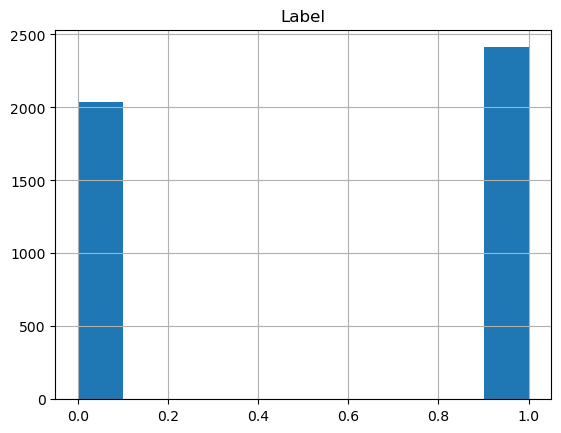

In [ ]:
df.hist()

In [ ]:
df.info()

In [ ]:
duplicate_rows = df[df.duplicated(subset = 'TimeSeries', keep = False)]

print(duplicate_rows)

<h1> Data Preprocessing </h1>

In [ ]:
# Convert to PyTorch tensors
time_series_tensor = torch.tensor(np.array(time_series_list), dtype=torch.float32)
label_tensor = torch.tensor(label_list, dtype=torch.float32)

# print(time_series_tensor.shape)
# print(label_tensor.shape)

channels = 18

# Normalize each channel individually
scaler = StandardScaler()
time_series_normalized = torch.zeros(time_series_tensor.shape)

# print(time_series_normalized.shape)
# print(time_series_normalized[0,0,0])

# Iterate over channels
for i in range(channels):
    time_series_normalized[:, :, i] = torch.tensor(scaler.fit_transform(time_series_tensor[:, :, i]))

# print(time_series_normalized.shape)

train_data, test_data, train_labels, test_labels = train_test_split(time_series_normalized, label_tensor, test_size = 0.2, shuffle = True, stratify = label_tensor)

print(torch.isnan(time_series_normalized).any())
print(torch.isnan(label_tensor).any())

# print(train_labels)
# print(test_labels)
